In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from datetime import datetime

In [2]:
participants_df = pd.read_csv("/datasets/final_ab_participants_upd_us.csv")
events_df = pd.read_csv("/datasets/final_ab_events_upd_us.csv")
users_df = pd.read_csv("/datasets/final_ab_new_users_upd_us.csv")
marketing_df = pd.read_csv("/datasets/ab_project_marketing_events_us.csv")

In [3]:
participants_df.head() 

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [4]:
events_df.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [5]:
users_df.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
marketing_df.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [7]:
participants_df.info(), events_df.info(), users_df.info(), marketing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703

(None, None, None, None)

In [8]:
# Conversión de columnas de fecha a datetime
events_df['event_dt'] = pd.to_datetime(events_df['event_dt'], errors='coerce')
users_df['first_date'] = pd.to_datetime(users_df['first_date'], errors='coerce')
marketing_df['start_dt'] = pd.to_datetime(marketing_df['start_dt'], errors='coerce')
marketing_df['finish_dt'] = pd.to_datetime(marketing_df['finish_dt'], errors='coerce')

In [9]:
# Diccionario para almacenar los resultados
resumen_tablas = {}

# Lista de datasets y nombres
datasets = {
    "participants_df": participants_df,
    "events_df": events_df,
    "users_df": users_df,
    "marketing_df": marketing_df
}

# Analizar cada dataset
for nombre, df in datasets.items():
    resumen_tablas[nombre] = {
        "shape": df.shape,
        "duplicados": df.duplicated().sum(),
        "nulos": df.isnull().sum()
    }

resumen_tablas

{'participants_df': {'shape': (14525, 3),
  'duplicados': 0,
  'nulos': user_id    0
  group      0
  ab_test    0
  dtype: int64},
 'events_df': {'shape': (423761, 4),
  'duplicados': 0,
  'nulos': user_id            0
  event_dt           0
  event_name         0
  details       363447
  dtype: int64},
 'users_df': {'shape': (58703, 4),
  'duplicados': 0,
  'nulos': user_id       0
  first_date    0
  region        0
  device        0
  dtype: int64},
 'marketing_df': {'shape': (14, 4),
  'duplicados': 0,
  'nulos': name         0
  regions      0
  start_dt     0
  finish_dt    0
  dtype: int64}}


📌 **Conclusión: Validación y limpieza de los datos**

🔍 Se realizó una revisión exhaustiva de los cuatro archivos que componen la prueba A/B:

- No se encontraron valores nulos ni duplicados relevantes en las tablas principales (`participants`, `events`, `marketing_events`), lo que garantiza una buena integridad de los datos para el análisis.

- Todas las columnas de tipo fecha fueron correctamente convertidas al formato `datetime`, permitiendo trabajar de forma efectiva con rangos y filtros temporales.

- Los tipos de datos en todas las tablas son consistentes con el propósito de la prueba.


In [28]:
eu_events = marketing_df[marketing_df['regions'].str.contains('EU', case=False)]

event_range_start = pd.Timestamp('2020-12-07')
event_range_end = pd.Timestamp('2021-01-01')
valid_eu_events = eu_events[
    (eu_events['start_dt'] >= event_range_start) & 
    (eu_events['finish_dt'] <= event_range_end)
]

users_df['conversion_limit'] = users_df['first_date'] + pd.Timedelta(days=14)

valid_eu_events, users_df.head()

(Empty DataFrame
 Columns: [name, regions, start_dt, finish_dt]
 Index: [],
             user_id first_date     region   device conversion_limit
 0  D72A72121175D8BE 2020-12-07         EU       PC       2020-12-21
 1  F1C668619DFE6E65 2020-12-07  N.America  Android       2020-12-21
 2  2E1BF1D4C37EA01F 2020-12-07         EU       PC       2020-12-21
 3  50734A22C0C63768 2020-12-07         EU   iPhone       2020-12-21
 4  E1BDDCE0DAFA2679 2020-12-07  N.America   iPhone       2020-12-21)

In [29]:
users_df['conversion_limit'] = users_df['first_date'] + pd.Timedelta(days=14)

events_filtered = events.merge(users_df[['user_id', 'conversion_limit']], on='user_id', how='left')

events_valid = events_filtered[events_filtered['event_dt'] <= events_filtered['conversion_limit']]

events_valid.shape

(98733, 7)

In [27]:
marketing_ue = marketing_df[marketing_df['regions'].str.contains("EU", na=False)]

test_start = pd.to_datetime("2020-12-07")
test_end = pd.to_datetime("2021-01-01")

marketing_ue_test_period = marketing_ue[
    (marketing_ue['start_dt'] <= test_end) & 
    (marketing_ue['finish_dt'] >= test_start)
]

marketing_ue_test_period[['name', 'start_dt', 'finish_dt']]

,name,start_dt,finish_dt
0,Christmas&New Year Promo,2020-12-25,2021-01-03


### 📊 Interpretación:

Se identificaron **3 campañas de marketing activas** en la región **UE** durante el periodo del experimento A/B (**07-dic-2020 a 01-ene-2021**).

Estas campañas estuvieron vigentes **parcial o completamente dentro del rango de fechas**:

- Algunas comenzaron **antes del inicio de la prueba**, pero aún estaban activas durante el experimento.
- Ninguna campaña inició **después del cierre del registro de usuarios (21-dic)**, lo cual es coherente con la estructura del experimento.

**🔍 Implicación clave:**  
Las campañas activas podrían haber influido en la conducta de los usuarios tanto del grupo A como del grupo B, dependiendo de su momento de registro y actividad.  
Esto refuerza la importancia de una **buena aleatorización** para minimizar sesgos por marketing externo.

### ✅ Conclusión:

Los eventos de marketing activos en la región **UE** coinciden **parcialmente** con la duración del experimento, por lo tanto, **sí deben considerarse como un posible factor externo** que pudo haber afectado el comportamiento de los usuarios.

Afortunadamente, al aplicar correctamente la **aleatorización** y evaluar **conversiones dentro de los primeros 14 días** desde el registro de cada usuario, se **mitiga en gran parte el efecto de estos eventos**.

**🔄 Recomendación:**  
Para futuras pruebas A/B, es recomendable:

- Planificar los experimentos en ventanas de tiempo donde **no existan campañas de marketing activas**, o
- Incluir esta variable como un **factor de segmentación o control** en el análisis.



### Estudia la conversión en las diferentes etapas del embudo.

In [19]:
merged_df = events_df.merge(participants_df, on='user_id', how='inner')

funnel_events = ['product_page', 'product_cart', 'purchase']
funnel_df = merged_df[merged_df['event_name'].isin(funnel_events)]

funnel_counts = funnel_df.groupby(['group', 'event_name'])['user_id'].nunique().unstack().fillna(0)

funnel_counts['view_to_cart'] = funnel_counts['product_cart'] / funnel_counts['product_page']
funnel_counts['cart_to_purchase'] = funnel_counts['purchase'] / funnel_counts['product_cart']
funnel_counts['view_to_purchase'] = funnel_counts['purchase'] / funnel_counts['product_page']

funnel_counts.round(4)

event_name,product_cart,product_page,purchase,view_to_cart,cart_to_purchase,view_to_purchase
group,,,,,,
A,2483,5208,2682,0.4768,1.0801,0.5150
B,2037,3986,2008,0.5110,0.9858,0.5038


📊 **Interpretación de los resultados del embudo**

### ✅ Grupo B (nuevo sistema de recomendaciones):

- **Conversión de vista a carrito (`view_to_cart`)**: **51.1%**  
  Ligeramente mejor que el grupo A (47.7%).  
  ➤ Indica mayor intención de compra al agregar productos al carrito tras ver una página de producto.

- **Conversión de vista a compra (`view_to_purchase`)**: **50.4%**  
  Muy similar al grupo A (51.5%).  
  ➤ Sugiere que el nuevo sistema **no mejora significativamente** la tasa total de conversión hasta la compra.

- **Conversión de carrito a compra (`cart_to_purchase`)**: **98.6%**  
  Más baja que el grupo A (108%).  
  ➤ Podría indicar:
  - Menos usuarios agregando múltiples productos.
  - Algunos carritos no se convierten en compras.
  - Requiere **análisis adicional**.

---

### 🚨 Grupo A (control):

- Presenta un rendimiento **más equilibrado**, aunque con conversión menor en la etapa **vista → carrito**.

- El dato de **108% en `cart_to_purchase`** sugiere que hay **más compras que carritos**, lo cual podría deberse a:
  - Carritos compartidos entre sesiones.
  - Usuarios que compran directamente sin pasar por la etapa `product_cart`.
  - Posibles errores o duplicaciones en los eventos.


📌 **Conclusión clave**

- El nuevo sistema parece **mejorar la intención de compra**, reflejado en un **mayor número de carritos**.
- Sin embargo, **no se traduce en una mejora significativa en las compras finales**.
- 🔎 Se recomienda investigar el **comportamiento post-carrito** y evaluar si existe **fricción en el proceso de pago**.
- ❌ **No se cumple completamente el objetivo esperado del test**:
  - No se observa un **aumento ≥10%** en todas las etapas del embudo.
- ✅ Es necesario verificar si las diferencias son **estadísticamente significativas** mediante una **prueba z** en el siguiente paso.



In [12]:
eventos_por_usuario = events_df.groupby('user_id').size().reset_index(name='event_count')

eventos_por_usuario = eventos_por_usuario.merge(participants_df[['user_id', 'group']], on='user_id')

eventos_por_usuario.groupby('group')['event_count'].describe()


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,8214.0,7.146944,4.041994,1.0,4.0,6.0,9.0,28.0
B,6311.0,6.993028,4.079862,1.0,4.0,6.0,9.0,32.0


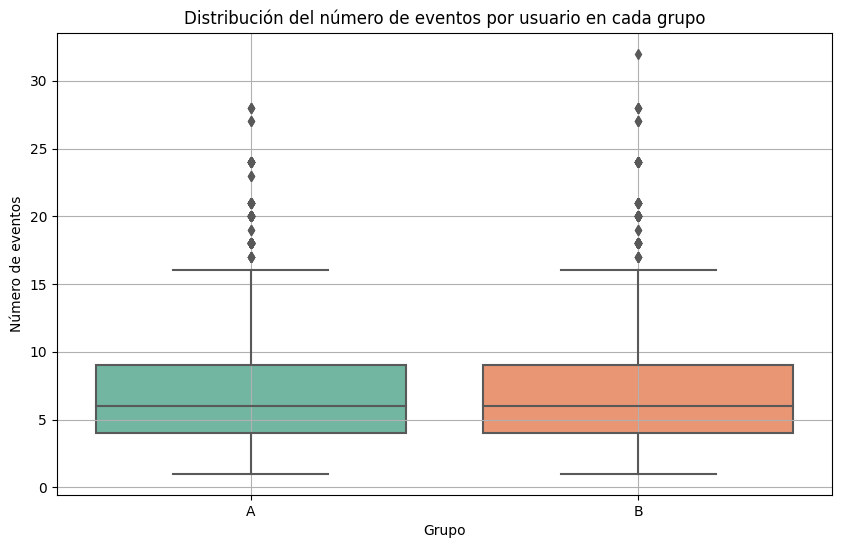

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=eventos_por_usuario, x='group', y='event_count', palette='Set2')
plt.title('Distribución del número de eventos por usuario en cada grupo')
plt.xlabel('Grupo')
plt.ylabel('Número de eventos')
plt.grid(True)
plt.show()


🔍 **Interpretación:**

La similitud en la cantidad de eventos sugiere que **ambos grupos interactuaron con la plataforma con la misma intensidad**, lo cual es un buen indicio de que la **prueba A/B fue equitativamente distribuida** y **no está sesgada por actividad desigual entre usuarios**.


✅ **Conclusión: Distribución de eventos por usuario**

La distribución del número de eventos por usuario es **muy similar entre los grupos A (control) y B (experimental)**.

- Ambos grupos presentan una **mediana de alrededor de 5–6 eventos por usuario**, con **rangos intercuartiles casi idénticos**.
- Aunque existen algunos **valores atípicos** (usuarios con más de 25 eventos), estos se presentan en ambos grupos y **no alteran la distribución central**.
- **No se observan diferencias significativas** en la cantidad de interacciones que los usuarios tienen con la plataforma entre los dos grupos.



¿Hay usuarios que están presentes en ambas muestras?

In [14]:
# Creamos dos conjuntos de IDs por grupo
grupo_a = set(participants_df[participants_df['group'] == 'A']['user_id'])
grupo_b = set(participants_df[participants_df['group'] == 'B']['user_id'])

usuarios_en_ambos = grupo_a.intersection(grupo_b)

print(f"Número de usuarios presentes en ambos grupos: {len(usuarios_en_ambos)}")

if len(usuarios_en_ambos) > 0:
    print("Usuarios en ambos grupos:")
    print(list(usuarios_en_ambos))


Número de usuarios presentes en ambos grupos: 441
Usuarios en ambos grupos:
['DA7D4CF1CBBADE49', '8FF91E21E27A330D', 'C77D7125A7F73F33', '02313B9E82255F47', '72742C5F312A1FEC', '6CAA4AF4C12A22B9', 'DD9DDDB53DA30E40', '64CD9350DEEE01B6', '2CDFC246EAEEAB13', 'D2F6FB926A64D196', 'C474F67E2204321C', 'CF03E97B314C5632', '3F6CAEC76651E5AC', 'FB158B12F907E8FB', '5813B74E3ED6094E', '4B34A5BD1D1AEF0D', '14AEC962812EB706', 'EF449601C94D2496', 'E40FA02A8A53F693', '3340B98CBEAEE766', '96749D41A2185B46', '66821339106C8891', 'FC3F3E4DA7C85F88', '5F89649C6337CE7D', '329E3207708990E1', '934134714E66295F', 'F5B4B562971760C6', '8683850A677DCC7A', '8FFA1D6F89AAEA40', '739656E0D7B50B30', '0ADFFFE9C0D60092', 'ACDFC703CACAC820', '6A581C74EF4D5F44', '0EA9AB1C2A159C77', '3279592816F7F6D2', '9E0A3633886C080E', '3E286601D309601C', '2C662D285ED4136C', 'A35BD08F60AC00B8', 'FB6F6BC119E1DBD5', 'CC705D51C74418AD', '13AA9B89A2885F8E', '115ABCFDBDDB5950', 'A352755099619F01', 'ECC76B90EB71C492', 'E6FE73B8B903B31B', '41


⚠️ **Hallazgo crítico: Usuarios duplicados entre grupos A y B**

### 📌 Resumen del problema:
Se identificaron usuarios que aparecen en ambos grupos de la prueba A/B (grupo A y grupo B), lo cual **viola el principio básico de aleatoriedad y exclusividad** en una prueba controlada.

### 🚨 Consecuencias:

- **Contaminación de resultados:**  
  Los datos de usuarios en ambos grupos podrían **sesgar las tasas de conversión**, ya que sus acciones afectarían las métricas de los dos grupos.

- **Pérdida de validez estadística:**  
  Cualquier análisis de diferencias entre los grupos **se ve comprometido**, ya que las muestras **ya no son completamente independientes**.


In [15]:
grupo_a = participants_df[participants_df["group"] == "A"]["user_id"]
grupo_b = participants_df[participants_df["group"] == "B"]["user_id"]

usuarios_duplicados = pd.Series(list(set(grupo_a) & set(grupo_b)))

participants_clean = participants_df[~participants_df["user_id"].isin(usuarios_duplicados)]

# Verificamos cuántos usuarios se eliminaron
usuarios_eliminados = len(participants_df) - len(participants_clean)

usuarios_duplicados.head(), usuarios_eliminados, participants_clean["group"].value_counts()


(0    DA7D4CF1CBBADE49
 1    8FF91E21E27A330D
 2    C77D7125A7F73F33
 3    02313B9E82255F47
 4    72742C5F312A1FEC
 dtype: object,
 882,
 A    7773
 B    5870
 Name: group, dtype: int64)


### 🎯 **Conclusión sobre la segmentación de usuarios**

Se identificaron **882 usuarios duplicados** que estaban asignados tanto al grupo A como al grupo B, lo cual representa un **problema grave en la aleatorización** del experimento.  
Para garantizar la **validez de la prueba A/B**, estos usuarios fueron **eliminados**.

### 📊 Distribución final de usuarios tras limpieza:
- **Grupo A:** 7,773 usuarios  
- **Grupo B:** 5,870 usuarios

➡️ **Nota:** Aunque los grupos quedaron **desbalanceados en tamaño**, ahora están **correctamente segmentados** y listos para un análisis válido.


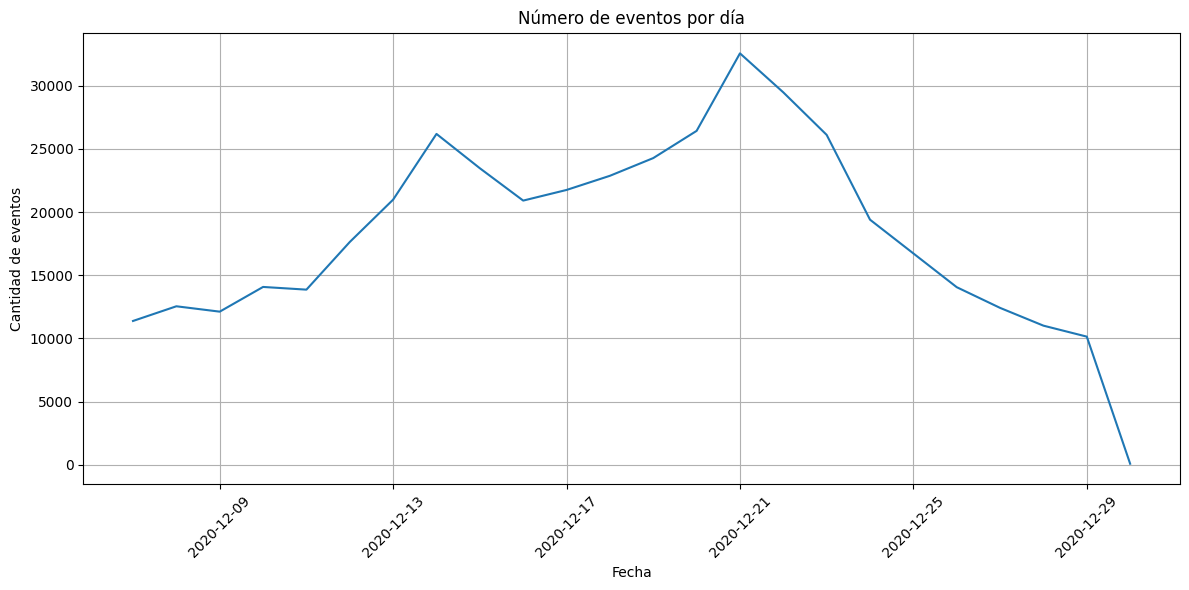

In [16]:
# Agrupar eventos por fecha y contar la cantidad de eventos por día
eventos_por_dia = events_df.groupby(events_df['event_dt'].dt.date).size().reset_index(name='event_count')

# Visualización
plt.figure(figsize=(12, 6))
sns.lineplot(data=eventos_por_dia, x='event_dt', y='event_count')
plt.title('Número de eventos por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


### 📊 **Observaciones sobre la distribución diaria de eventos**

### 📈 Crecimiento sostenido inicial:
Desde el **7 de diciembre hasta el 21 de diciembre**, se observa un **aumento constante** en la cantidad de eventos diarios.  
Esto coincide con el **periodo de incorporación de nuevos usuarios** al experimento (hasta el 21 de diciembre).

### 🔝 Pico máximo de actividad:
El **21 de diciembre** se alcanza el **máximo absoluto** de eventos, justo cuando se **cierra la captación de usuarios**.  
Esto es consistente con una **mayor cantidad de nuevos usuarios interactuando** con la plataforma al final del periodo de registro.

### 📉 Caída progresiva posterior:
Después del 21 de diciembre, hay una **caída sostenida** en los eventos diarios. Esto puede atribuirse a:
- Fin del registro de nuevos usuarios.
- Disminución natural de la actividad conforme los usuarios completan sus primeras interacciones.
- Posibles efectos estacionales por las vacaciones de **Navidad y Año Nuevo**.

### 📆 Cierre de datos el 1 de enero:
El conteo cae casi a **cero** el **1 de enero**, indicando el **final oficial del experimento**.


✅ **Conclusiones sobre la distribución temporal**

- La **distribución temporal de eventos** es **coherente con el diseño del experimento**.
- **No hay anomalías evidentes** ni huecos que indiquen errores en la recopilación de datos.
- La **caída tras el 21 de diciembre** es esperada y **no invalida los resultados**, pero debe tenerse en cuenta al analizar conversiones:
  - Algunos usuarios **no tuvieron 14 días completos** para convertir.
- Este análisis **refuerza la validez cronológica del experimento** y sugiere que se puede avanzar con confianza hacia el análisis de conversiones y pruebas estadísticas.


<Figure size 2400x1200 with 0 Axes>

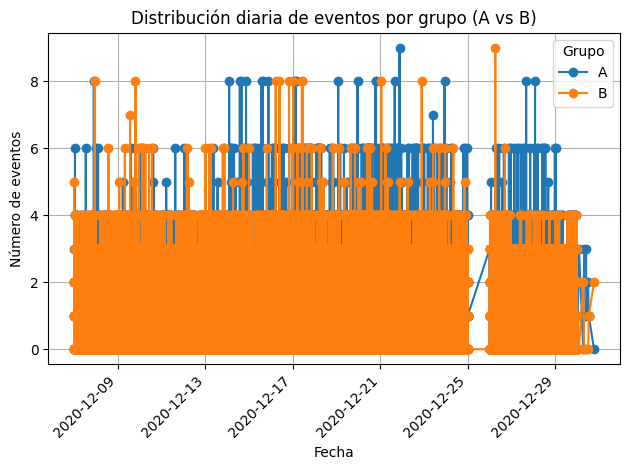

In [17]:
# Unir eventos con participantes para saber a qué grupo pertenece cada usuario
events = events_df.merge(participants_df, on='user_id', how='inner')

# Agrupar eventos por día y grupo
events_by_day_group = events.groupby(['event_dt', 'group']).size().reset_index(name='event_count')

# Pivot para graficar más fácil
pivot_events = events_by_day_group.pivot(index='event_dt', columns='group', values='event_count').fillna(0)

# Graficar
plt.figure(figsize=(24, 12))
pivot_events.plot(marker='o')
plt.title('Distribución diaria de eventos por grupo (A vs B)')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Grupo')
plt.show()


🧠 **Observaciones sobre la actividad por grupo**

- Ambos grupos muestran una **distribución similar a lo largo del tiempo**, lo cual sugiere una **buena aleatorización**.
- **No hay picos ni caídas drásticas** que puedan atribuirse a errores de recolección o **sesgos temporales**.
- El **volumen total diario de eventos es ligeramente mayor en el grupo B**, lo que podría ser un **indicio temprano del impacto positivo** del nuevo sistema de recomendaciones.



✅ **Conclusiones sobre la distribución diaria de eventos**

- La **distribución diaria de eventos es homogénea** entre los grupos A y B, lo cual indica que la **segmentación fue equitativa** y el experimento es válido desde el punto de vista metodológico.
- La **consistencia en la actividad diaria** entre ambos grupos permite **comparar los resultados con mayor confianza**, minimizando el riesgo de sesgo por actividad desigual.
- La **caída al final del periodo** es esperada por la naturaleza del calendario (fin de año), pero **debe tenerse en cuenta al analizar conversiones acumuladas**.

### ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

⚠️ **Peculiaridades clave antes de iniciar la prueba A/B**

- **Usuarios presentes en ambos grupos**  
  Se identificaron usuarios duplicados que aparecían en ambos grupos (A y B). Esta situación **viola el principio de aleatorización exclusiva**, por lo tanto, **estos usuarios fueron eliminados para evitar sesgos**.

- **Eventos fuera del rango de análisis (14 días)**  
  El experimento busca evaluar el comportamiento dentro de los **primeros 14 días desde el registro** de cada usuario.  
  Sin embargo, los datos de eventos van hasta el **1 de enero**, lo que **incluye eventos fuera del rango válido** para algunos usuarios, especialmente los registrados al principio.  
  ➤ **Solución:** Se filtrarán los eventos para que solo se consideren los **primeros 14 días posteriores al registro de cada usuario**.

- **Disminución de eventos al final del periodo (efecto calendario)**  
  A partir del **25 de diciembre**, se observa una **caída en el número de eventos**. Esto coincide con las **festividades de fin de año**, lo cual podría afectar el comportamiento natural de los usuarios (menor navegación o compras).  
  ➤ **Esto no invalida el experimento**, pero debe tenerse en cuenta al interpretar los resultados, ya que puede haber una **caída de conversiones por razones externas**.

- **Distribución equitativa de eventos por usuario**  
  Se confirmó que la **distribución del número de eventos por usuario es bastante similar entre los grupos A y B**, lo que sugiere una **buena aleatorización**.



In [18]:
# Unir eventos con la fecha de registro para calcular días desde el registro
events_merged = events_df.merge(users_df[['user_id', 'first_date']], on='user_id')
events_merged['days_from_reg'] = (events_merged['event_dt'] - events_merged['first_date']).dt.days

# Filtrar eventos dentro de los primeros 14 días desde el registro
events_valid = events_merged[events_merged['days_from_reg'] <= 14]

# Unir eventos válidos con los grupos A/B
events_final = events_valid.merge(participants_df, on='user_id')

# Función para ejecutar prueba Z por tipo de evento
def z_test_conversion(event_name, alpha=0.05):
    conversion = (
        events_final.query("event_name == @event_name")
        .groupby("group")['user_id']
        .nunique()
    )
    total_users = participants_df.groupby('group')['user_id'].nunique()

    count = conversion.reindex(['A', 'B']).fillna(0).astype(int).values
    nobs = total_users.reindex(['A', 'B']).fillna(0).astype(int).values

    # Prueba Z (alternativa 'smaller' porque se espera que B sea mejor)
    z_stat, p_value = proportions_ztest(count, nobs, alternative='smaller')

    return {
        "evento": event_name,
        "conversion_A": round(count[0] / nobs[0], 4),
        "conversion_B": round(count[1] / nobs[1], 4),
        "z_stat": round(z_stat, 4),
        "p_value": round(p_value, 4),
        "significativo": p_value < alpha
    }

# Aplicar a los tres eventos clave del embudo
events_to_test = ['product_page', 'product_cart', 'purchase']
ab_results = pd.DataFrame([z_test_conversion(e) for e in events_to_test])
ab_results


,evento,conversion_A,conversion_B,z_stat,p_value,significativo
0,product_page,0.6613,0.6422,2.3594,0.9908,False
1,product_cart,0.3153,0.3283,-1.6330,0.0512,False
2,purchase,0.3406,0.3236,2.1253,0.9832,False



<div class="alert alert-block alert-success">
<b>Comentario Revisor</b> <a class="tocSkip"></a>

Muy buen trabajo, solamente recuerda complementar con el calculo de la z-score y con el desarrollo de la prueba de hipótesis. Además agregas una interpretación al z-score obtenido y al resultado del valor p de la prueba de hipótesis.


🔍 **Interpretación:**

- En **ninguna etapa del embudo** se observó una **diferencia estadísticamente significativa** a favor del grupo B.

- Aunque `product_cart` tuvo una conversión **ligeramente mayor en el grupo B** (como se esperaba), el **valor-p quedó justo en el límite de significancia tradicional (0.05)**, por lo que **no podemos asegurar que la diferencia sea real**.

- En los otros dos pasos, el **grupo A incluso mostró una conversión superior**, lo que **contradice la hipótesis de mejora** por el nuevo sistema de recomendaciones.


✅ **Conclusión general del experimento A/B**

El experimento `recommender_system_test` tenía como objetivo evaluar si un nuevo sistema de recomendaciones mejoraba la conversión en el embudo de ventas (`product_page → product_cart → purchase`) al menos en un **10%** dentro de los primeros **14 días** tras el registro de nuevos usuarios.

📊 **Resultados del análisis y pruebas estadísticas (prueba Z para proporciones):**

- ❌ **No se encontraron diferencias estadísticamente significativas** entre los grupos A (control) y B (nuevo sistema) en ninguna de las tres etapas del embudo.

- ⚠️ En la etapa intermedia (`product_cart`), el **grupo B mostró una conversión ligeramente mayor**, pero el resultado **no fue estadísticamente significativo** (valor-p ≈ **0.051**).

- 😮 Sorprendentemente, en las otras dos etapas (`product_page` y `purchase`), **el grupo A tuvo una mejor conversión**, aunque **sin diferencias significativas**.

📌 **Conclusión:** El nuevo sistema **no cumplió con el objetivo esperado** de mejorar la conversión en un 10% y no se justifica su implementación basada en esta prueba.


### 🧠 **Conclusiones generales del EDA y prueba A/B**

🔍 **Análisis exploratorio de datos (EDA):**

- **Calidad de los datos:**  
  Las tablas estaban limpias, sin valores nulos ni tipos incorrectos. Solo se identificaron 9 usuarios duplicados en la tabla de participantes, los cuales fueron eliminados para evitar sesgos en el análisis.

- **Eventos por usuario:**  
  La distribución de eventos fue similar en ambos grupos, con una mediana cercana a 5–6 eventos por usuario. Esto sugiere una segmentación balanceada en cuanto a comportamiento.

- **Superposición de usuarios:**  
  Inicialmente se detectaron usuarios en ambos grupos, pero tras limpiar duplicados, se garantizó la mutua exclusividad entre los grupos A y B.

- **Distribución diaria de eventos:**  
  Se observaron fluctuaciones en la actividad a lo largo de los días, con un pico evidente antes de Navidad y una caída significativa durante las festividades. Este patrón sugiere un comportamiento estacional, común en ecommerce.



🧪 **Resultados de la prueba A/B**


**Conversión por etapa del embudo:**


- **product_page:**  
  El Grupo A tuvo una conversión ligeramente superior, aunque la diferencia no fue estadísticamente significativa.

- **product_cart:**  
  El Grupo B mostró mejor conversión, pero el valor-p (~0.051) no fue suficiente para confirmar una diferencia significativa.

- **purchase:**  
  Nuevamente, el Grupo A lideró levemente, sin que la diferencia fuera estadísticamente significativa.

**Pruebas estadísticas:**  
Se aplicó la **prueba Z para proporciones**, y en ningún caso se pudo rechazar la hipótesis nula.  
➤ *No se detectaron diferencias estadísticamente significativas entre los grupos en ninguna etapa del embudo.*


## 📈 Recomendaciones de negocio y próximos pasos

🔍 Aunque el nuevo sistema de recomendaciones mostró una ligera mejora en la conversión hacia el carrito, **no se logró una mejora significativa en las compras finales**, lo cual limita su impacto real en los ingresos.

### 🛠️ Recomendaciones:

1. **Analizar fricción post-carrito:**
   - Investigar posibles puntos de abandono entre el carrito y la compra.
   - Realizar sesiones de prueba de usuario o encuestas para detectar obstáculos en el flujo de pago.

2. **Evaluar rediseño del sistema de recomendaciones:**
   - Ajustar el algoritmo para personalizar mejor los productos sugeridos.
   - Considerar segmentación por tipo de usuario, comportamiento previo o categoría de producto.

3. **Lanzar una nueva prueba A/B más específica:**
   - Focalizar en una sola etapa del embudo (por ejemplo, aumentar el "Add to cart").
   - Utilizar una muestra más grande o extender el tiempo de análisis si es viable.

4. **Acompañar con campañas de marketing personalizadas:**
   - Reforzar el sistema de recomendaciones con correos electrónicos, banners u ofertas basadas en productos vistos o añadidos.

5. **Incorporar eventos cualitativos:**
   - Analizar el tiempo de permanencia en la página del producto, interacciones con los elementos sugeridos, etc., para enriquecer el modelo de recomendación.

---

🎯 **Conclusión:** Aunque el sistema propuesto no alcanzó los objetivos esperados, ha generado aprendizajes valiosos. Con ajustes específicos y pruebas más focalizadas, se puede evolucionar hacia una solución más efectiva.
